We study subluminal GWs through correlations in PTA.

In [1]:
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt
import os # requires *full path*

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # for insets, if needed

import numpy as np
from PTAfast.tensor import Tensor
from PTAfast.vector import Vector
from PTAfast.hellingsdowns import HellingsDowns as HD

We consider the binned correlations data set by NANOGrav, and the GW common process amplitude. This is visualized below.

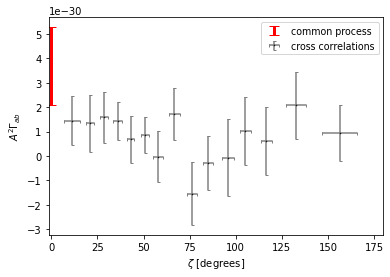

In [2]:
# import binned correlations data
data_loc = 'https://raw.githubusercontent.com/reggiebernardo/galileon_pta/main/orf_n12p5.txt'
n12p5 = np.loadtxt(data_loc)

# cross correlations
tta_rad = n12p5[0]
tta = tta_rad*180/np.pi
Dtta = n12p5[1]*180/np.pi
gma = n12p5[2]
Dgma = n12p5[3]

# common spectrum process
CSP = {'ave': 1.92e-15, 'err': max((2.67 - 1.92)*1e-15, (1.92 - 1.37)*1e-15)/2}
A2Gma_ng125 = {'ave': CSP['ave']**2, 'err': 2*CSP['ave']*CSP['err'] + CSP['err']**2}

# visualize points
fig, ax = plt.subplots()
ax.errorbar(0, A2Gma_ng125['ave'], yerr = A2Gma_ng125['err'], label = 'common process', \
            fmt = 'r.', markersize = 3, ecolor = 'red', elinewidth = 3, capsize = 5)
ax.errorbar(tta, gma, xerr = Dtta, yerr = Dgma, label = 'cross correlations', \
            fmt = 'k.', markersize = 1, ecolor = 'gray', elinewidth = 1.5, capsize = 1.5)
ax.set_xlim(-1.5, 180)
ax.set_xlabel(r'$\zeta$ [degrees]')
ax.set_ylabel(r'$A^2 \Gamma_{ab}$')
ax.legend(loc = 'upper right', prop = {'size': 9.5})
plt.show()

We now setup the likelihoods for tensor and vector correlations given the data set. This is then used together with `cobaya` and later with `getdist` to study the posteriors of the GW parameters.

In [3]:
# setup reference HD
lMax = 60
Zta = tta_rad # angle separations in NG12.5

def chi2_tensors(A2, v, fD = 100):    
    # calculate ORF of half luminal tensor
    NEorf = Tensor(lm = lMax, v = v, fD = fD) # v = GW speed, fD = distance

    orf = NEorf.get_ORF(Zta) # add option return_tv = True for total var
    ave = orf['ORF']
    err = np.sqrt(orf['CV'])
    
    Err2 = gma**2 # + (A2*err)**2
    Devi = (A2*ave - gma)/np.sqrt(Err2)
    chi2_corr = sum(Devi**2)
    
    Gaa = NEorf.gaa_T()/Tensor(lm = 10, v = 1, fD = fD).gaa_T()
    model_csp = A2*Gaa
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2

    return chi2_corr + chi2_csp

def loglike_tensors(A2, v, fD = 100):
    return -0.5*chi2_tensors(A2, v, fD)

# vectors

def chi2_vectors(A2, v, fD = 100):    
    # calculate ORF of vector
    NEorf = Vector(lm = lMax, v = v, fD = fD) # v = GW speed, fD = distance

    orf = NEorf.get_ORF(Zta) # add option return_tv = True for total var
    ave = orf['ORF']
    err = np.sqrt(orf['CV'])
    
    Err2 = (A2*err)**2 + Dgma**2
    Devi = (A2*ave - gma)/np.sqrt(Err2)
    chi2_corr = sum(Devi**2)
    
    Gaa = NEorf.gaa_V()/Vector(lm = 10, v = 1, fD = fD).gaa_V()
    model_csp = A2*Gaa
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2

    return chi2_corr + chi2_csp

def loglike_vectors(A2, v, fD = 100):
    return -0.5*chi2_vectors(A2, v, fD)

# Hellings Downs curve

def chi2_HD(A2):    
    # calculate ORF of HD
    NEorf = HD(lm = lMax)

    orf = NEorf.get_ORF(Zta) # add option return_tv = True for total var
    ave = orf['ORF']
    err = np.sqrt(orf['CV'])
    
    Err2 = Dgma**2 # + (A2*err)**2 
    Devi = (A2*ave - gma)/np.sqrt(Err2)
    chi2_corr = sum(Devi**2)
    
    Gaa = 1
    model_csp = A2*Gaa
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2

    return chi2_corr + chi2_csp

def loglike_HD(A2):
    return -0.5*chi2_HD(A2)

# GW monopole

def chi2_mon(A2):    
    # calculate ORF of HD
    Gab = 0.5
    chi2_corr = sum(((A2*Gab - gma)/Dgma)**2)
    
    Gaa = 1
    model_csp = A2*Gaa
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2

    return chi2_corr + chi2_csp

def loglike_mon(A2):
    return -0.5*chi2_mon(A2)

# derived variables

def mg(v):
    '''velocity to graviton mass in 10^{-22} eV'''
    h_evy = 1.310542e-22 # electron volts year
    f_pta = 1 # per year
    mg_2 = ((h_evy*f_pta)**2)*(1 - v**2)
    return np.sqrt(mg_2)*(1e22)

See code `subluminalgws_ng125.py` for implementation. Sampling with Cobaya, e.g., `cobaya-run subluminal_xxx.yaml` or with MPI `mpirun -n 8 cobaya-run subluminal_xxx.yaml`.

Below, we import the results obtained from the sampling (saved in a folder "chains").

In [ ]:
folder_file_1 = 'chains/subltensors'
folder_file_2 = 'chains/hd'
folder_file_3 = 'chains/mon'
folder_file_4 = 'chains/sublvectors'

gdsamples_1 = loadMCSamples(os.path.abspath(folder_file_1))
gdsamples_2 = loadMCSamples(os.path.abspath(folder_file_2))
gdsamples_3 = loadMCSamples(os.path.abspath(folder_file_3))
gdsamples_4 = loadMCSamples(os.path.abspath(folder_file_4))

# get statistics
stats_1 = gdsamples_1.getMargeStats()
stats_2 = gdsamples_2.getMargeStats()
stats_3 = gdsamples_3.getMargeStats()
stats_4 = gdsamples_4.getMargeStats()

# convergence of each chains
print('tensor : ', gdsamples_1.getGelmanRubin())
print('vector : ', gdsamples_4.getGelmanRubin())

We show the posteriors for the GW correlations in the following.

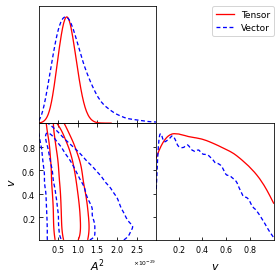

In [5]:
gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot([gdsamples_1, gdsamples_4], \
                     ["A2", "v"], \
                     contour_ls = ['-', '--'], \
                     contour_lws = [1.3, 1.3], \
                     contour_colors = ['red', 'blue'], \
                     filled = False, \
                     title_limit = 0, \
                     legend_labels = ['Tensor', 'Vector'], \
                     legend_loc = 'upper right', \
                     param_limits = {'A2': (0.1e-30, 3e-29)})
plt.show()

We also constrain the graviton mass through the GW velocity. This relation is explicit below.

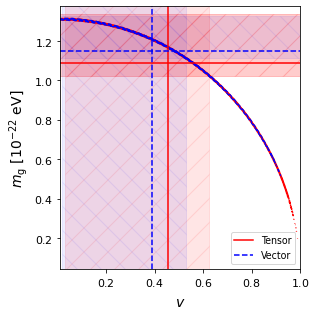

In [6]:
g = gdplt.get_subplot_plotter(width_inch = 4.5)
g.plot_2d([gdsamples_1, gdsamples_4], ['v', 'mg'], \
          colors = ['red', 'blue'], ls = ['-', '--'])

# tensor stats
plt.axvline(stats_1.parWithName('v').mean, \
            color = 'red', ls = '-', lw = 1.5, label = 'Tensor')
plt.axvspan(stats_1.parWithName('v').limits[0].lower, \
            stats_1.parWithName('v').limits[0].upper, \
            alpha = 0.1, color = 'red', hatch = '/')
g.add_y_marker(stats_1.parWithName('mg').mean, ls = '-', lw = 1.5, color = 'red')
plt.fill_between(np.linspace(0, 1, 50), \
                 [stats_1.parWithName('mg').limits[0].lower]*50, \
                 [stats_1.parWithName('mg').limits[0].upper]*50, \
                 alpha = 0.2, color = 'red', hatch = '/')

# vector stats
plt.axvline(stats_4.parWithName('v').mean, \
            color = 'blue', ls = '--', lw = 1.5, label = 'Vector')
plt.axvspan(stats_4.parWithName('v').limits[0].lower, \
            stats_4.parWithName('v').limits[0].upper, \
            alpha = 0.07, color = 'blue', hatch = '\\')
g.add_y_marker(stats_4.parWithName('mg').mean, ls = '--', lw = 1.5, color = 'blue')
plt.fill_between(np.linspace(0, 1, 50), \
                 [stats_4.parWithName('mg').limits[0].lower]*50, \
                 [stats_4.parWithName('mg').limits[0].upper]*50, \
                 alpha = 0.07, color = 'blue', hatch = '\\')

plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.show()

Now, we look at the graviton mass posteriors. This complements the previous plot.

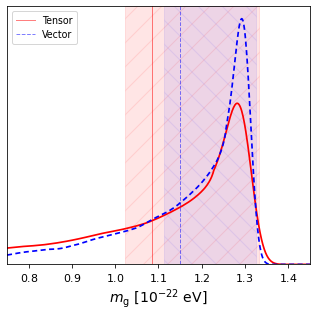

In [7]:
g = gdplt.get_subplot_plotter(width_inch = 4.5)
g.plot_1d([gdsamples_1, gdsamples_4], 'mg', lws = [1.7, 1.7], \
          normalized = True, no_ylabel = True, \
          colors = ['red', 'blue'], ls = ['-', '--'], lims = [0.75, 1.45])

# tensor stats
plt.axvline(stats_1.parWithName('mg').mean, \
            alpha = 0.5, color = 'red', ls = '-', lw = 1.0, label = 'Tensor')
plt.axvspan(stats_1.parWithName('mg').limits[0].lower, \
            stats_1.parWithName('mg').limits[0].upper, \
            alpha = 0.1, color = 'red', hatch = '/')

# vector stats
plt.axvline(stats_4.parWithName('mg').mean, \
            alpha = 0.5, color = 'blue', ls = '--', lw = 1.0, label = 'Vector')
plt.axvspan(stats_4.parWithName('mg').limits[0].lower, \
            stats_4.parWithName('mg').limits[0].upper, \
            alpha = 0.07, color = 'blue', hatch = '\\')

plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

We next print the statistics for each correlations model including the HD and the GW-like monopole.

In [8]:
# AIC and BIC penalizes the number of free parameters, see Trotta Bayes in the sky
def AIC(LL, k):
    return 2*k - 2*LL

def BIC(LL, k, n):
    return k*np.log(n) - 2*LL

print('GW monopole/reference')
c2_monbf = stats_3.parWithName('chi2').bestfit_sample
aic_mon = AIC(-0.5*c2_monbf, 1)
bic_mon = BIC(-0.5*c2_monbf, 1, len(tta) + 1)

print('HD')
c2_HDbf = stats_2.parWithName('chi2').bestfit_sample
print('best chi^2 :', (c2_monbf - c2_HDbf)/(len(tta) + 1))
print('AIC :', aic_mon - AIC(-0.5*c2_HDbf, 1))
print('BIC :', bic_mon - BIC(-0.5*c2_HDbf, 1, len(tta) + 1))
print()

print('subluminal tensor')
c2_subten = stats_1.parWithName('chi2').bestfit_sample
print('best chi^2 :', (c2_monbf - c2_subten)/(len(tta) + 1))
print('AIC :', aic_mon - AIC(-0.5*c2_subten, 2))
print('BIC :', bic_mon - BIC(-0.5*c2_subten, 2, len(tta) + 1))
print()

print('subluminal vector')
c2_subvec = stats_4.parWithName('chi2').bestfit_sample
print('best chi^2 :', (c2_monbf - c2_subvec)/(len(tta) + 1))
print('AIC :', aic_mon - AIC(-0.5*c2_subvec, 2))
print('BIC :', bic_mon - BIC(-0.5*c2_subvec, 2, len(tta) + 1))
print()

GW monopole/reference
HD
best chi^2 : -0.10367281250000004
AIC : -1.6587650000000007
BIC : -1.6587650000000007

subluminal tensor
best chi^2 : 0.061672593750000004
AIC : -1.0132385
BIC : -1.7858272222397797

subluminal vector
best chi^2 : -0.10981506249999995
AIC : -3.757040999999999
BIC : -4.529629722239781



We plot the mean curves for each model to visualize them. In addition we consider the cosmic variance for the tensor correlations. But first we evaluate these using the best fit parameters and PTAfast.

In [9]:
# mean ORFs for tensor and vector
Zeta = np.logspace(np.log10(1e-3), np.log10(np.pi), 200)
TensorBForf = Tensor(lm = lMax, v = stats_1.parWithName('v').mean, fD = 100).get_ORF(Zeta)
A2Gab_TensorBF = stats_1.parWithName('A2').mean*TensorBForf['ORF']
A2Gab_TensorCV = stats_1.parWithName('A2').mean*np.sqrt(TensorBForf['CV']) + \
stats_1.parWithName('A2').err*TensorBForf['ORF']

VectorBForf = Vector(lm = lMax, v = stats_4.parWithName('v').mean, fD = 100).get_ORF(Zeta)
A2Gab_VectorBF = stats_4.parWithName('A2').mean*VectorBForf['ORF']
A2Gab_VectorCV = stats_4.parWithName('A2').mean*np.sqrt(VectorBForf['CV']) + \
stats_4.parWithName('A2').err*VectorBForf['ORF']

# mean HD, GW monopole
A2Gab_HDBF = stats_2.parWithName('A2').mean*HD(lm = lMax).get_ORF(Zeta)['ORF']
A2Gab_monBF = stats_3.parWithName('A2').mean*np.array([0.5]*len(Zeta))

Finally the mean curves are obtained and presented below together with their cosmic variances.

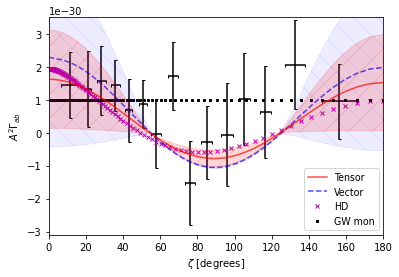

In [10]:
# plot best fits
fig, ax = plt.subplots()
ax.errorbar(tta, gma, xerr = Dtta, yerr = Dgma, zorder = 0,
            fmt = 'k.', markersize = 1, ecolor = 'black', elinewidth = 1.5, capsize = 1.5)

# tensor
ax.plot(Zeta*180/np.pi, A2Gab_TensorBF, zorder = 10, \
        alpha = 0.7, color = 'red', ls = '-', label = r'Tensor')
ax.fill_between(Zeta*180/np.pi, \
                A2Gab_TensorBF - A2Gab_TensorCV, \
                A2Gab_TensorBF + A2Gab_TensorCV, \
                zorder = 9, facecolor = 'red', edgecolor = 'red', \
                alpha = 0.15, hatch = '/')

# vector
ax.plot(Zeta*180/np.pi, A2Gab_VectorBF, zorder = 8, \
        alpha = 0.7, color = 'blue', ls = '--', label = r'Vector')
ax.fill_between(Zeta*180/np.pi, \
                A2Gab_VectorBF - A2Gab_VectorCV, \
                A2Gab_VectorBF + A2Gab_VectorCV, \
                zorder = 7, facecolor = 'blue', edgecolor = 'blue', \
                alpha = 0.070, hatch = '\\')

ax.plot(Zeta*180/np.pi, A2Gab_HDBF, 'mx', markersize = 4, label = 'HD', zorder = 1)
ax.plot(Zeta*180/np.pi, A2Gab_monBF, 'ks', markersize = 2, label = 'GW mon', zorder = 2)
ax.set_xlim(0, 180)
ax.set_ylim(-3.1e-30, 3.5e-30)
ax.set_xlabel(r'$\zeta$ [degrees]')
ax.set_ylabel(r'$A^2 \Gamma_{ab}$')
ax.legend(loc = 'lower right', prop = {'size': 9.5})
plt.show()

End of notebook